In [1]:
package_path = '../input/pytorch-image-models/pytorch-image-models-master' #'../input/efficientnet-pytorch-07/efficientnet_pytorch-0.7.0'
import sys; sys.path.append(package_path)

In [2]:
import numpy as np
import os
import pandas as pd
from fastai.vision.all import *
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import albumentations as A
from sklearn import metrics as sk_metrics

from glob import glob
from sklearn.model_selection import GroupKFold, StratifiedKFold
from skimage import io
import torch
from torch import nn
from datetime import datetime
import time
import random
import torchvision
from torchvision import transforms
from tqdm import tqdm

import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from  torch.cuda.amp import autocast, GradScaler

import warnings
import joblib
from sklearn.metrics import roc_auc_score, log_loss
from sklearn import metrics
import warnings
import cv2
import pydicom
import timm #from efficientnet_pytorch import EfficientNet
from scipy.ndimage.interpolation import zoom
from sklearn.metrics import log_loss

In [3]:
CFG = {
    'fold_num': 5,
    'seed': 719,
    'model_arch': 'tf_efficientnet_b4_ns',
    'img_size': 512,
    'epochs': 10,
    'train_bs': 32,
    'valid_bs': 32,
    'lr': 1e-4,
    'num_workers': 4,
    'accum_iter': 1, # suppoprt to do batch accumulation for backprop with effectively larger batch size
    'verbose_step': 1,
    'device': 'cuda:0',
    'tta': 3,
    'used_epochs': [6,7,8,9],
    'weights': [1,1,1,1]
}

In [4]:
BASE_DIR = "../input/cassava-leaf-disease-classification/"

In [5]:
sample = pd.read_csv("../input/cassava-leaf-disease-classification/sample_submission.csv", index_col=0)

In [6]:
with open(os.path.join(BASE_DIR, "label_num_to_disease_map.json")) as file:
    map_classes = json.loads(file.read())
    map_classes = {int(k) : v for k, v in map_classes.items()}
    
print(json.dumps(map_classes, indent=4))

{
    "0": "Cassava Bacterial Blight (CBB)",
    "1": "Cassava Brown Streak Disease (CBSD)",
    "2": "Cassava Green Mottle (CGM)",
    "3": "Cassava Mosaic Disease (CMD)",
    "4": "Healthy"
}


In [7]:
input_files = os.listdir(os.path.join(BASE_DIR, "train_images"))
print(f"There are {len(input_files)} images")

There are 21397 images


In [8]:
df_train = pd.read_csv(os.path.join(BASE_DIR, "train.csv"))

df_train["class_name"] = df_train["label"].map(map_classes)

df_train

image_id  label                           class_name
0      1000015157.jpg      0       Cassava Bacterial Blight (CBB)
1      1000201771.jpg      3         Cassava Mosaic Disease (CMD)
2       100042118.jpg      1  Cassava Brown Streak Disease (CBSD)
3      1000723321.jpg      1  Cassava Brown Streak Disease (CBSD)
4      1000812911.jpg      3         Cassava Mosaic Disease (CMD)
...               ...    ...                                  ...
21392   999068805.jpg      3         Cassava Mosaic Disease (CMD)
21393   999329392.jpg      3         Cassava Mosaic Disease (CMD)
21394   999474432.jpg      1  Cassava Brown Streak Disease (CBSD)
21395   999616605.jpg      4                              Healthy
21396   999998473.jpg      4                              Healthy

[21397 rows x 3 columns]

As mentioned in [this discussion thread](https://www.kaggle.com/c/cassava-leaf-disease-classification/discussion/198143), we can find following 4 types of disease.
* Cassava Bacterial Blight (CBB)
* Cassava Brown Streak Disease (CBSD)
* Cassava Green Mottle (CGM)
* Cassava Mosaic Disease (CMD)

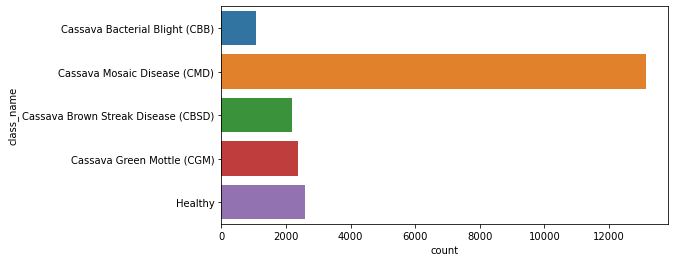

In [9]:
plt.figure(figsize=(8, 4))
sns.countplot(y="class_name", data=df_train);

In [10]:
sample

label
image_id             
2216849948.jpg      4

In [11]:
def visualize_func(image_ids, labels):
    plt.figure(figsize=(16, 12))
    
    for i, (image_id, label) in enumerate(zip(image_ids, labels)):
        plt.subplot(3, 3, i + 1)
        image = cv2.imread(os.path.join(BASE_DIR, "train_images", image_id))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        plt.imshow(image)
        plt.title(f"Class: {label}", fontsize=12)
        plt.axis("off")
    
    plt.show()

Total train images for class 0: 1087


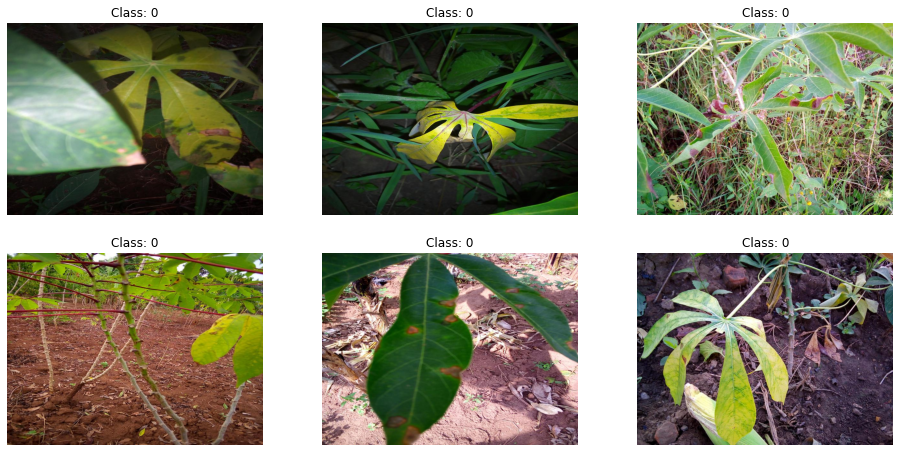

In [12]:
tmp_df = df_train[df_train["label"] == 0]
print(f"Total train images for class 0: {tmp_df.shape[0]}")

tmp_df = tmp_df.sample(6)
image_ids = tmp_df["image_id"].values
labels = tmp_df["label"].values

visualize_func(image_ids, labels)

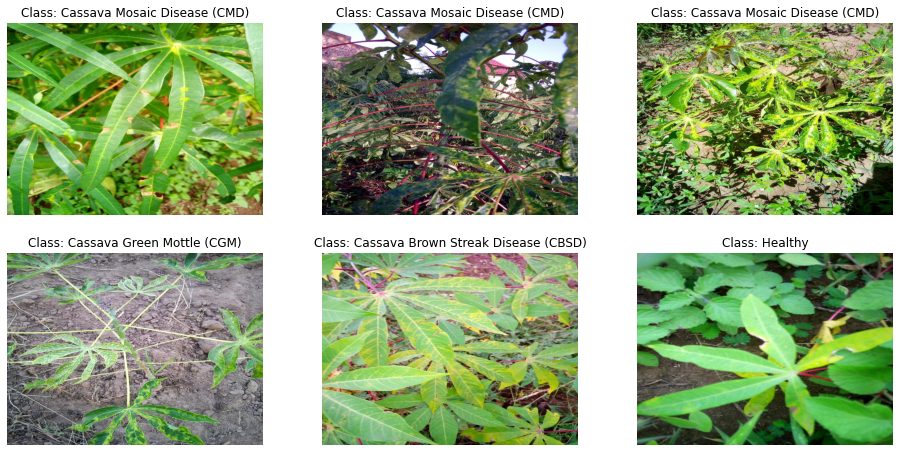

In [13]:
tmp_df = df_train.sample(6)
image_ids = tmp_df["image_id"].values
labels = tmp_df["class_name"].values

visualize_func(image_ids, labels)

Total train images for class 0: 1087


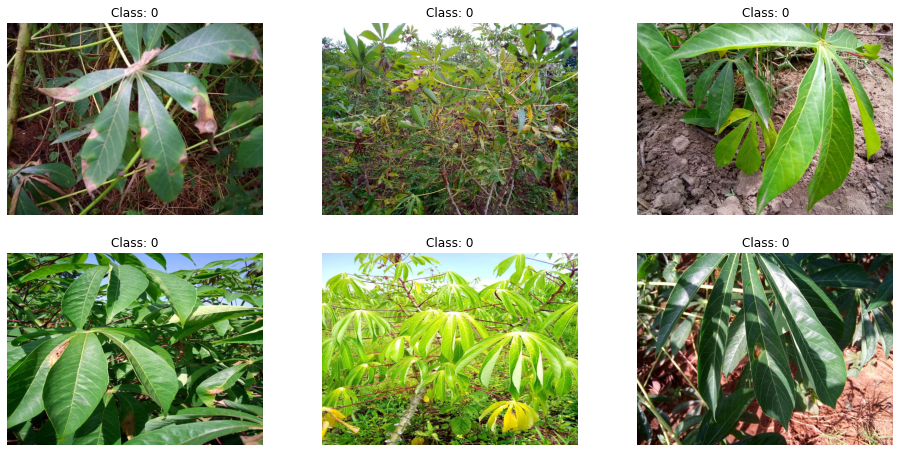

In [14]:
tmp_df = df_train[df_train["label"] == 0]
print(f"Total train images for class 0: {tmp_df.shape[0]}")

tmp_df = tmp_df.sample(6)
image_ids = tmp_df["image_id"].values
labels = tmp_df["label"].values

visualize_func(image_ids, labels)

Total train images for class 1: 2189


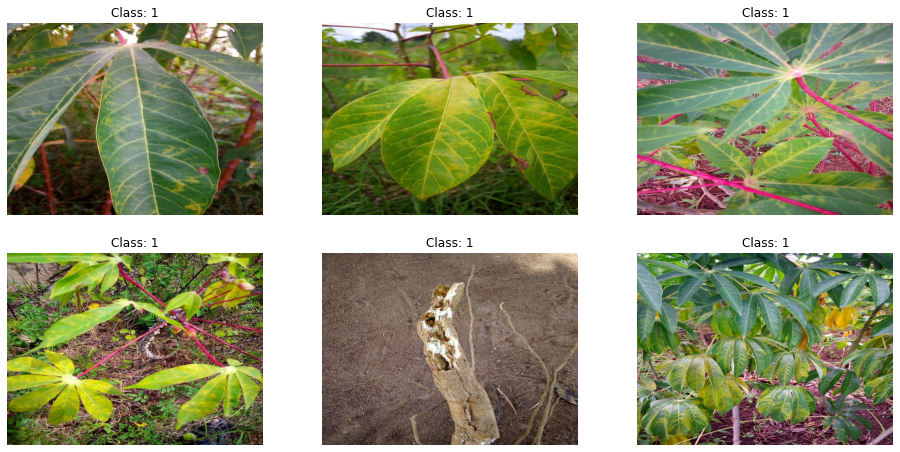

In [15]:
tmp_df = df_train[df_train["label"] == 1]
print(f"Total train images for class 1: {tmp_df.shape[0]}")

tmp_df = tmp_df.sample(6)
image_ids = tmp_df["image_id"].values
labels = tmp_df["label"].values

visualize_func(image_ids, labels)

Total train images for class 2: 2386


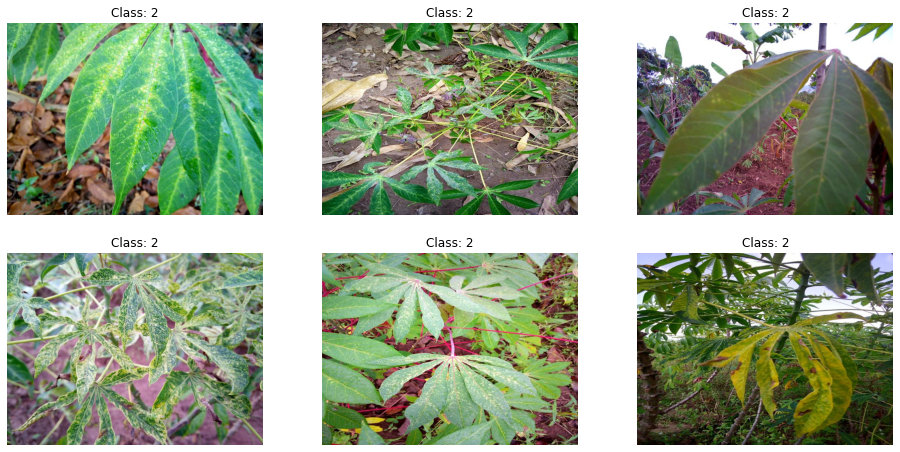

In [16]:
tmp_df = df_train[df_train["label"] == 2]
print(f"Total train images for class 2: {tmp_df.shape[0]}")

tmp_df = tmp_df.sample(6)
image_ids = tmp_df["image_id"].values
labels = tmp_df["label"].values

visualize_func(image_ids, labels)

Total train images for class 3: 13158


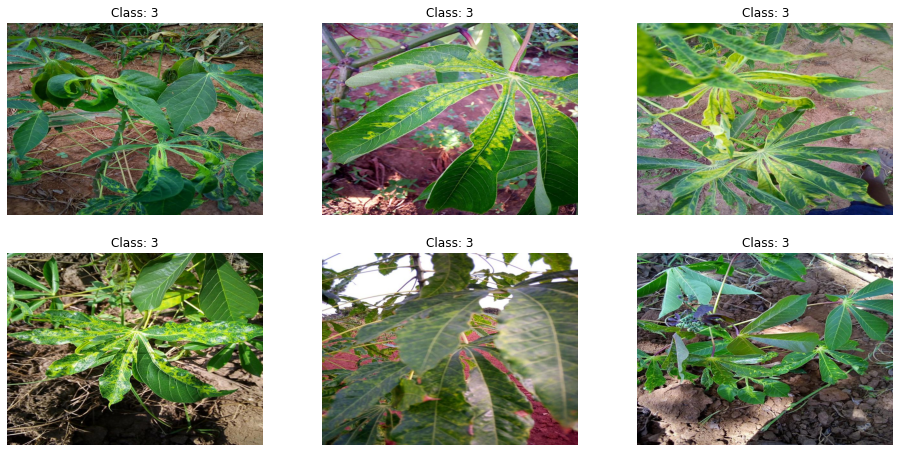

In [17]:
tmp_df = df_train[df_train["label"] == 3]
print(f"Total train images for class 3: {tmp_df.shape[0]}")

tmp_df = tmp_df.sample(6)
image_ids = tmp_df["image_id"].values
labels = tmp_df["label"].values

visualize_func(image_ids, labels)

Total train images for class 4: 2577


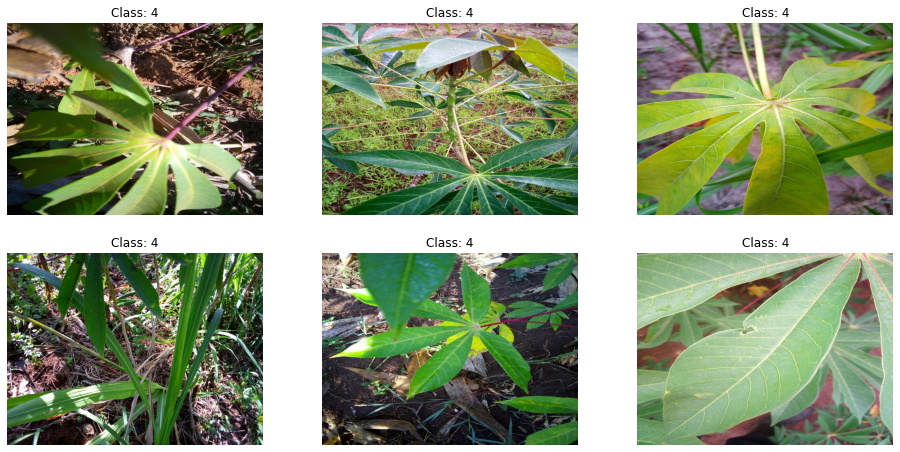

In [18]:
tmp_df = df_train[df_train["label"] == 4]
print(f"Total train images for class 4: {tmp_df.shape[0]}")

tmp_df = tmp_df.sample(6)
image_ids = tmp_df["image_id"].values
labels = tmp_df["label"].values

visualize_func(image_ids, labels)

# Helper Functions

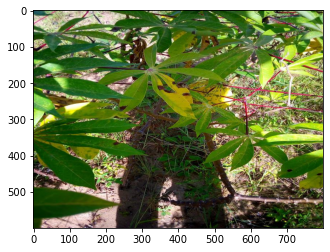

In [19]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
def get_img(path):
    im_bgr = cv2.imread(path)
    im_rgb = im_bgr[:, :, ::-1]
    #print(im_rgb)
    return im_rgb

img = get_img('../input/cassava-leaf-disease-classification/train_images/1000015157.jpg')
plt.imshow(img)
plt.show()

# Dataset

In [20]:
class CassavaDataset(Dataset):
    def __init__(
        self, df, data_root, transforms=None, output_label=True
    ):
        
        super().__init__()
        self.df = df.reset_index(drop=True).copy()
        self.transforms = transforms
        self.data_root = data_root
        self.output_label = output_label
    
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, index: int):
        
        # get labels
        if self.output_label:
            target = self.df.iloc[index]['label']
          
        path = "{}/{}".format(self.data_root, self.df.iloc[index]['image_id'])
        
        img  = get_img(path)
        
        if self.transforms:
            img = self.transforms(image=img)['image']
            
        # do label smoothing
        if self.output_label == True:
            return img, target
        else:
            return img      

# Define Train\Validation Image Augmentations

In [21]:
from albumentations import (
    HorizontalFlip, VerticalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine, RandomResizedCrop,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose, Normalize, Cutout, CoarseDropout, ShiftScaleRotate, CenterCrop, Resize
)

from albumentations.pytorch import ToTensorV2

from albumentations import (
    HorizontalFlip, VerticalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine, RandomResizedCrop,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose, Normalize, Cutout, CoarseDropout, ShiftScaleRotate, CenterCrop, Resize
)


from albumentations.pytorch import ToTensorV2

def get_train_transforms():
    return Compose([
            RandomResizedCrop(CFG['img_size'], CFG['img_size']),
            Transpose(p=0.5),
            HorizontalFlip(p=0.5),
            VerticalFlip(p=0.5),
            ShiftScaleRotate(p=0.5),
            HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
            RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5),
            Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
            CoarseDropout(p=0.5),
            Cutout(p=0.5),
            ToTensorV2(p=1.0),
        ], p=1.)

  
        
def get_valid_transforms():
    return Compose([
            CenterCrop(CFG['img_size'], CFG['img_size'], p=1.),
            Resize(CFG['img_size'], CFG['img_size']),
            Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
            ToTensorV2(p=1.0),
        ], p=1.)

def get_inference_transforms():
    return Compose([
            RandomResizedCrop(CFG['img_size'], CFG['img_size']),
            Transpose(p=0.5),
            HorizontalFlip(p=0.5),
            VerticalFlip(p=0.5),
            HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
            RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5),
            Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
            ToTensorV2(p=1.0),
        ], p=1.)

# Model

In [22]:
class CassvaImgClassifier(nn.Module):
    def __init__(self, model_arch, n_class, pretrained=False):
        super().__init__()
        self.model = timm.create_model(model_arch, pretrained=pretrained)
        n_features = self.model.classifier.in_features
        self.model.classifier = nn.Linear(n_features, n_class)
        
    def forward(self, x):
        x = self.model(x)
        return x

# Main Loop

In [23]:
def inference_one_epoch(model, data_loader, device):
    model.eval()

    image_preds_all = []
    
    pbar = tqdm(enumerate(data_loader), total=len(data_loader))
    for step, (imgs) in pbar:
        imgs = imgs.to(device).float()
        
        image_preds = model(imgs)   #output = model(input)
        image_preds_all += [torch.softmax(image_preds, 1).detach().cpu().numpy()]
        
    
    image_preds_all = np.concatenate(image_preds_all, axis=0)
    return image_preds_all

In [24]:
if __name__ == '__main__':
     # for training only, need nightly build pytorch

    seed_everything(CFG['seed'])
    
    folds = StratifiedKFold(n_splits=CFG['fold_num']).split(np.arange(df_train.shape[0]), df_train.label.values)
    
    for fold, (trn_idx, val_idx) in enumerate(folds):
        # we'll train fold 0 first
        if fold > 0:
            break 

        print('Inference fold {} started'.format(fold))

        valid_ = df_train.loc[val_idx,:].reset_index(drop=True)
        valid_ds = CassavaDataset(valid_, '../input/cassava-leaf-disease-classification/train_images/', transforms=get_inference_transforms(), output_label=False)
        
        test = pd.DataFrame()
        test['image_id'] = list(os.listdir('../input/cassava-leaf-disease-classification/test_images/'))
        test_ds = CassavaDataset(test, '../input/cassava-leaf-disease-classification/test_images/', transforms=get_inference_transforms(), output_label=False)
        
        val_loader = torch.utils.data.DataLoader(
            valid_ds, 
            batch_size=CFG['valid_bs'],
            num_workers=CFG['num_workers'],
            shuffle=False,
            pin_memory=False,
        )
        
        tst_loader = torch.utils.data.DataLoader(
            test_ds, 
            batch_size=CFG['valid_bs'],
            num_workers=CFG['num_workers'],
            shuffle=False,
            pin_memory=False,
        )

        device = torch.device(CFG['device'])
        model = CassvaImgClassifier(CFG['model_arch'], df_train.label.nunique()).to(device)
        
        val_preds = []
        tst_preds = []
        
        #for epoch in range(CFG['epochs']-3):
        for i, epoch in enumerate(CFG['used_epochs']):    
            model.load_state_dict(torch.load('../input/pytorch-efficientnet-baseline-train-amp-aug/{}_fold_{}_{}'.format(CFG['model_arch'], fold, epoch)))
            
            with torch.no_grad():
                for _ in range(CFG['tta']):
                    val_preds += [CFG['weights'][i]/sum(CFG['weights'])/CFG['tta']*inference_one_epoch(model, val_loader, device)]
                    tst_preds += [CFG['weights'][i]/sum(CFG['weights'])/CFG['tta']*inference_one_epoch(model, tst_loader, device)]

        val_preds = np.mean(val_preds, axis=0) 
        tst_preds = np.mean(tst_preds, axis=0) 
        
        print('fold {} validation loss = {:.5f}'.format(fold, log_loss(valid_.label.values, val_preds)))
        print('fold {} validation accuracy = {:.5f}'.format(fold, (valid_.label.values==np.argmax(val_preds, axis=1)).mean()))
        
        del model
        torch.cuda.empty_cache()

Inference fold 0 started


AssertionError: Torch not compiled with CUDA enabled

# References & Credits

* [Cassava Leaf Disease Classification](https://www.kaggle.com/c/cassava-leaf-disease-classification)
* [Cassava classification - EDA & fastai starter](https://www.kaggle.com/tanlikesmath/cassava-classification-eda-fastai-starter)
* [Pytorch Efficientnet Baseline [Inference] TTA](https://www.kaggle.com/khyeh0719/pytorch-efficientnet-baseline-inference-tta)